# Reddit AI Bot Recognizing Animals and Commenting

### 1. Imports and options

**1.1 Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import cv2
from time import time
import PIL; from PIL import Image, ImageOps
import time
import matplotlib.pyplot as plt
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

Using TensorFlow backend.


**1.2 Options**

In [2]:
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.default_content_setting_values.notifications" : 2}
chrome_options.add_experimental_option("prefs", prefs)
chrome_options.add_argument("--start-maximized")
os.chdir(r'C:\Users\Nicolas\Documents\Scraping\redditbot')

### 2. Surfing with the webdriver

**2.1 Starting**

In [168]:
driver = webdriver.Chrome(r'C:/Users/Nicolas/Downloads/chromedriver.exe', options=chrome_options)

In [169]:
driver.get('https://www.reddit.com/login/?dest=https%3A%2F%2Fwww.reddit.com%2F')

**2.2 Logging in**

2.2.1 Username

In [170]:
user = driver.find_element_by_id('loginUsername')

In [171]:
user.send_keys('Raww_Bot')

2.2.2 Password

In [172]:
pw = driver.find_element_by_id('loginPassword')

In [173]:
pw.send_keys('B33pB00p!')

In [174]:
pw.send_keys(Keys.ENTER)

**2.3 Browsing r/aww**

2.3.1 Opening the page

In [175]:
puppers = 'https://www.reddit.com/r/rarepuppers'

In [176]:
driver.get(puppers)

2.3.2 Scrolling down

In [177]:
SCROLL_PAUSE_TIME = 0.5

# Get scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

**2.4 Scraping cute pictures**

2.4.1 Initializing list, getting pics

In [178]:
pics = []
elements = []

In [179]:
for i in driver.find_elements_by_tag_name('img'):
    elements.append(i)
    pics.append(i.get_attribute("src"))

In [180]:
pictures = [x for i, x in enumerate(np.array(pics, dtype=str)) if x.startswith('https://preview.redd.it')]

In [181]:
inx = [i for i, x in enumerate(np.array(pics, dtype=str)) if x.startswith('https://preview.redd.it')]

In [182]:
parents = []
for elem in np.array(elements)[inx]:
    parents.append(elem.find_element_by_xpath('..').find_element_by_xpath('.'\
                    '.').find_element_by_xpath('..').get_attribute("href"))

2.4.2 Visualizing pictures

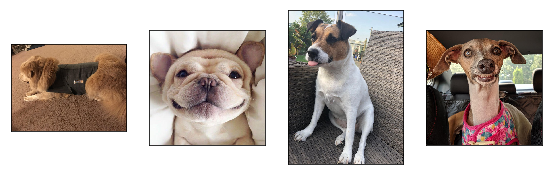

In [183]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand=np.random.randint(len(pictures))
    _ = urlopen(pictures[rand])
    ax = plt.imread(_, 'jpg')
    plt.imshow(ax)
    yticks = plt.xticks([]); yticks = plt.yticks([])
    #plt.title(str(parents[rand]).split('/')[-2].replace('_', ' ').title())

2.4.3 The pictures now reside in:

In [184]:
pictures[:10]

['https://preview.redd.it/oa5ctto7ohc31.jpg?width=640&crop=smart&auto=webp&s=cb850ec0232e2eeefe70d5d8bd4676c9ba8c6a85',
 'https://preview.redd.it/99eufnmn9gc31.jpg?width=640&crop=smart&auto=webp&s=6afceb74c20f37422bfcd8bce16173e64c167a7c',
 'https://preview.redd.it/nrdrnqkxylc31.jpg?width=640&crop=smart&auto=webp&s=67bcefef53b32733f4cfd579f9682af80e618b2e',
 'https://preview.redd.it/98soz6bj6mc31.jpg?width=640&crop=smart&auto=webp&s=4a74874044fd4af96e9076704ff4b37541cbd072',
 'https://preview.redd.it/j53dj2ehhlc31.jpg?width=640&crop=smart&auto=webp&s=3c4fdd70b768ff81349e7829e9ac5db92c61ac16',
 'https://preview.redd.it/72jg36suwkc31.jpg?width=640&crop=smart&auto=webp&s=48b42e19588bea24433a7cec775064442aff7d82',
 'https://preview.redd.it/fczm7wt65kc31.jpg?width=640&crop=smart&auto=webp&s=4f25ee23c0c95a8fe4b6bab5a5748d3eb3a3165d',
 'https://preview.redd.it/d3pk3aiqyjc31.jpg?width=640&crop=smart&auto=webp&s=5f7dcd27fe9023088e790a5d242298ac21318659',
 'https://preview.redd.it/n80wke42yhc31.

In [218]:
picture_names = []
for picture in pictures:
    picture_names.append(picture[-20:])

In [219]:
picture_names[:10]

['d5d8bd4676c9ba8c6a85',
 'd8bce16173e64c167a7c',
 'd579f9682af80e618b2e',
 '76704ff4b37541cbd072',
 '7829e9ac5db92c61ac16',
 '7cec775064442aff7d82',
 'bab5a5748d3eb3a3165d',
 '0a5d242298ac21318659',
 'c0947871cbc3c503d0fc',
 '303415558584b3e1c45d']

### 3. Preparing the images for convolutional neural networks

**3.1 Cropping**

In [203]:
rand = np.random.randint(len(pictures))

3.1.1 Uncropped picture

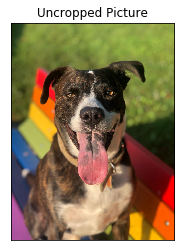

In [204]:
mypic = urlopen(pictures[rand])
mypic = plt.imread(mypic, 'jpg') 
plt.imshow(mypic)
yticks = plt.xticks([]); yticks = plt.yticks([])
title = plt.title('Uncropped Picture')
plt.show()

3.1.2 Cropping function

In [205]:
def crop(img):
    if img.shape[0]<img.shape[1]: # it means horizontal photo
        x = img.shape[0]
        y = img.shape[1]
        crop_img = img[: , int(y/2-x/2):int(y/2+x/2)]
    else:
        x = img.shape[1]
        y = img.shape[0]
        crop_img = img[int(y/2-x/2):int(y/2+x/2) , :]

    return crop_img

3.1.3 Cropped picture

In [206]:
mypic = crop(mypic)

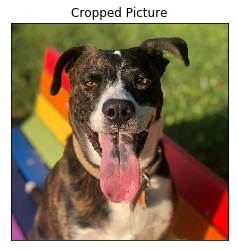

In [207]:
plt.imshow(mypic)
yticks = plt.xticks([]); yticks = plt.yticks([])
title = plt.title('Cropped Picture')
plt.show()

**3.2 Resizing**

3.2.1 Resizing

In [208]:
mypic = Image.fromarray(mypic).resize((224, 224))

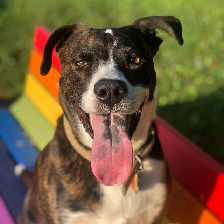

In [209]:
mypic

3.2.2 Back into an array

In [210]:
mypic = np.array(mypic)
mypic[0][:10]

array([[41, 63, 25],
       [43, 65, 27],
       [44, 66, 27],
       [49, 72, 28],
       [52, 75, 29],
       [55, 79, 31],
       [61, 84, 30],
       [67, 88, 32],
       [74, 95, 36],
       [79, 99, 36]], dtype=uint8)

3.2.3 Reshaping for VGG-16

In [212]:
mypic = mypic.reshape(1, 224, 224, 3)

### 4. Feeding the picture to a neural network

**4.1 Instantiating the model**

In [33]:
model = VGG16()

Instructions for updating:
Colocations handled automatically by placer.


**4.2 Making predictions**

In [213]:
yhat = model.predict(mypic)

**4.3 Decoding the predicted classes**

In [214]:
label = decode_predictions(yhat, top=1000)

In [215]:
label[0][:10]

[('n02093428', 'American_Staffordshire_terrier', 0.6364312),
 ('n02109047', 'Great_Dane', 0.13301715),
 ('n02093256', 'Staffordshire_bullterrier', 0.10737156),
 ('n02091032', 'Italian_greyhound', 0.021275135),
 ('n02091134', 'whippet', 0.020293271),
 ('n02100236', 'German_short-haired_pointer', 0.018827327),
 ('n02107142', 'Doberman', 0.011942296),
 ('n02088632', 'bluetick', 0.004902833),
 ('n02108089', 'boxer', 0.0044054883),
 ('n02105412', 'kelpie', 0.0031559847)]

**4.4 Making a Reddit comment**

In [275]:
comment = 'Nice dog! {} am I right??'.format(label[0][0][1].replace('_', ' ').title())
comment

'Nice dog! American Staffordshire Terrier am I right??'

### 5. Commenting on the post

**5.1 Loading the URL**

In [263]:
driver.get(parents[rand])

**5.2 Writing in the textbox**

In [276]:
textbox = driver.find_element_by_xpath('//*[@id="SHORTCUT_FOCUSABLE_DIV"]/div'\
    '[2]/div/div/div/div[2]/div[3]/div[1]/div/div[2]/div[2]/div/div/div[3]/div[2]/div[3]/div/div')

In [277]:
textbox.click()

In [278]:
textbox = driver.find_element_by_xpath('//*[@id="SHORTCUT_FOCUSABLE_DIV"]/div'\
            '[2]/div/div/div/div[2]/div[3]/div[1]/div/div[2]/div[2]/div/div[1]/textarea')

In [279]:
textbox.send_keys(comment)

**5.3 Submitting the comment**

In [280]:
submit = driver.find_element_by_xpath('//*[@id="SHORTCUT_FOCUSABLE_DIV"]/div[2]/div'\
                    '/div/div/div[2]/div[3]/div[1]/div/div[2]/div[2]/div/div[2]/div[1]/button')

In [281]:
submit.click()

**5.4 Looking at the result (screencap)**

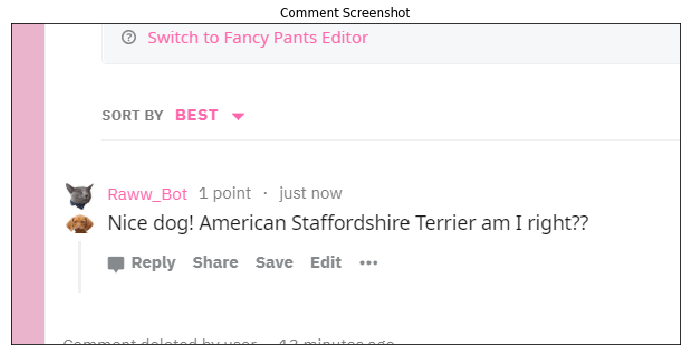

In [308]:
driver.save_screenshot("comment.png")
screenshot = plt.imread('comment.png', 'jpg')
fig=plt.figure(figsize=(12, 6))
yticks=plt.yticks([]); xticks=plt.xticks([])
plt.title('Comment Screenshot')
show = plt.imshow(screenshot[600:, :600])

### 6. All of this in a function

**6.1 Building the function**

In [312]:
def compliment_dog_owner(number):
    picture = urlopen(pictures[number])
    picture = plt.imread(picture, 'jpg') 
    picture = crop(picture)
    picture = Image.fromarray(picture).resize((224, 224))
    picture = np.array(picture)
    picture = picture.reshape(1, 224, 224, 3)
    yhat = model.predict(picture)
    label = decode_predictions(yhat, top=1000)
    race = label[0][0][1].replace('_', ' ').lower()
    driver.get(parents[number])
    textbox = driver.find_element_by_xpath('//*[@id="SHORTCUT_FOCUSABLE_DIV"]/div'\
    '[2]/div/div/div/div[2]/div[3]/div[1]/div/div[2]/div[2]/div/div/div[3]/div[2]/div[3]/div/div')
    textbox.click()
    textbox = driver.find_element_by_xpath('//*[@id="SHORTCUT_FOCUSABLE_DIV"]/div'\
            '[2]/div/div/div/div[2]/div[3]/div[1]/div/div[2]/div[2]/div/div[1]/textarea')
    comment = 'Nice dog! {} am I right??'.format(label[0][0][1].replace('_', ' ').title())
    textbox.send_keys(comment)
    submit = driver.find_element_by_xpath('//*[@id="SHORTCUT_FOCUSABLE_DIV"]/div[2]/div'\
                    '/div/div/div[2]/div[3]/div[1]/div/div[2]/div[2]/div/div[2]/div[1]/button')
    submit.click()

**6.2 Running the function**

In [313]:
compliment_dog_owner(np.random.randint(len(pictures)))

**6.3 Making a screencap**

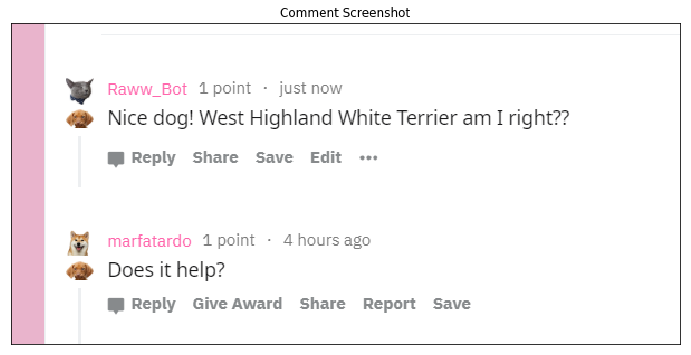

In [317]:
driver.execute_script("window.scrollTo(0, 900)") 
driver.save_screenshot("comment2.png")
screenshot = plt.imread('comment2.png', 'jpg')
fig=plt.figure(figsize=(12, 6))
yticks=plt.yticks([]); xticks=plt.xticks([])
plt.title('Comment Screenshot')
show = plt.imshow(screenshot[600:, :600])

Here's the Reddit profile: *[u/Raww_Bot](https://www.reddit.com/user/Raww_Bot)*